## 👁 Food Vision Big™

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle |
| Train data | 75,750 images | 7,575 images |
| Test data | 25,250 images | 25,250 images |
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) |

In [1]:
# check the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-147827de-30ff-fbc8-c12a-76f6838f416e)


In [2]:
# import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
from tensorflow.keras import layers
from helper_functions import create_tensorboard_callback, confusion_matrix, pred_and_plot, plot_loss_curves, compare_historys, calculate_results

In [3]:
# load food101 dataset from tensorflow datasets
import tensorflow_datasets as tfds
'food101' in tfds.list_builders()

True

In [4]:
(trian_data, test_data), data_info = tfds.load('food101', split = ['train', 'validation'],
                                               shuffle_files = True, as_supervised = True,
                                               with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ9WFSZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteQ9WFSZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
data_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = data_info.features['label'].names

In [9]:
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [10]:
image = trian_data.take(1)
image

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for img, label in image:
  print(img, label)

tf.Tensor(
[[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]

 [[136  91  60]
  [137  92  61]
  [139  94  63]
  ...
  [137  53   7]
  [135  51   5]
  [131  47   1]]

 ...

 [[130  23   3]
  [134  31  14]
  [132  36  24]
  ...
  [243 248 242]
  [243 248 242]
  [243 248 242]]

 [[128  22   0]
  [129  26   7]
  [124  28  14]
  ...
  [243 248 241]
  [242 247 240]
  [242 247 240]]

 [[132  26   2]
  [133  31   9]
  [126  29  13]
  ...
  [242 247 240]
  [242 247 240]
  [242 247 240]]], shape=(512, 512, 3), dtype=uint8) tf.Tensor(31, shape=(), dtype=int64)


In [12]:
img

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

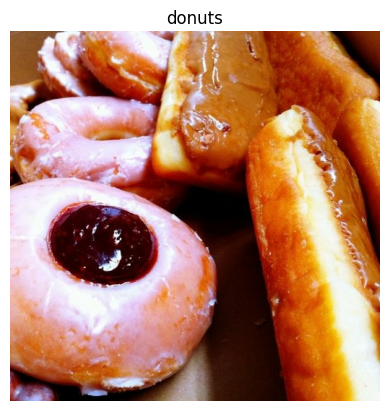

In [13]:
# plot an image
plt.imshow(img)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

In [14]:
# preprocessing images
def preprocess_img(images, labels, img_shape = 224):
  images = tf.image.resize(images, size = (img_shape, img_shape))
  return tf.cast(images, dtype = tf.float32), labels

In [15]:
# preprocessed single image
preprocessed_image = preprocess_img(img, label)[0]  # return image only without label
print('shape of image before preprocessed', img.shape, 'dtype', img.dtype)
print('shape of image after preprocessed', preprocessed_image.shape, 'dtype', preprocessed_image.dtype)


shape of image before preprocessed (512, 512, 3) dtype <dtype: 'uint8'>
shape of image after preprocessed (224, 224, 3) dtype <dtype: 'float32'>


In [16]:
#  Batch and Prepare dataset
train_data_prefetched = trian_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
train_data_prefetched = train_data_prefetched.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

test_data_prefetched = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
test_data_prefetched = test_data_prefetched.batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data_prefetched

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# create model callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience = 2,
                                                 verbose = 1, # print out when learning rate goes down
                                                 min_lr = 1e-7)

In [19]:
# setup mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = 'mixed_float16')

In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
# Bulid a Feature Extraction Model
tf.random.set_seed(42)

# get the EfficientNetB0 pretrained_model
base_model = tf.keras.applications.EfficientNetB4(include_top = False)
base_model.trainable = False

# create the functional Model
inputs = layers.Input(shape = (224, 224, 3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_names), activation = 'softmax', dtype = tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
model.summary()

71686520/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 181093 (707.39 KB)
Non-trainable params: 17673823 (67.42 MB)
_______________

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_2 float32 <Policy "float32">
efficientnetb4 float32 <Policy "mixed_float16">
global_average_pooling2d float32 <Policy "mixed_float16">
dense float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False


In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the Feature Extraction Model
history_1 = model.fit(train_data_prefetched, epochs = 5, steps_per_epoch = len(train_data_prefetched),
                      validation_data = test_data_prefetched, validation_steps = int(0.15 * len(test_data_prefetched)),
                      callbacks = [create_tensorboard_callback('training_logs',
                                                               'efficientnetb4_101_classes_all_data_feature_extract')])

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_feature_extract/20240515-130932
Epoch 1/5
2368/2368 [==============================] - 254s 99ms/step - loss: 1.7859 - accuracy: 0.5557 - val_loss: 1.2456 - val_accuracy: 0.6758
Epoch 2/5
2368/2368 [==============================] - 232s 97ms/step - loss: 1.3093 - accuracy: 0.6562 - val_loss: 1.1574 - val_accuracy: 0.6941
Epoch 3/5
2368/2368 [==============================] - 230s 96ms/step - loss: 1.1617 - accuracy: 0.6933 - val_loss: 1.1292 - val_accuracy: 0.6962
Epoch 4/5
2368/2368 [==============================] - 231s 97ms/step - loss: 1.0643 - accuracy: 0.7164 - val_loss: 1.0922 - val_accuracy: 0.7060
Epoch 5/5
2368/2368 [==============================] - 232s 97ms/step - loss: 0.9898 - accuracy: 0.7351 - val_loss: 1.0945 - val_accuracy: 0.7087


In [ ]:
model.evaluate(test_data_prefetched)

790/790 [==============================] - 71s 90ms/step - loss: 1.0936 - accuracy: 0.7043


[1.0936495065689087, 0.7043168544769287]

In [ ]:
model.save('/content/drive/MyDrive/efficientnetb4_feature_extract_model_mixed_precision')

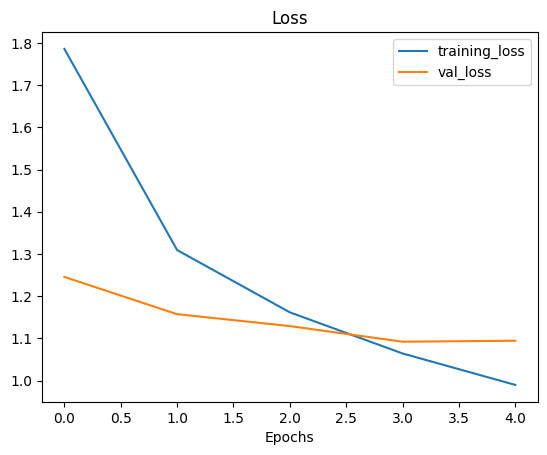

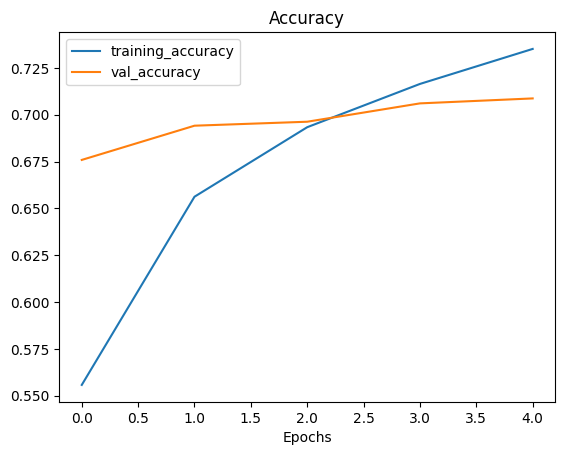

In [ ]:
plot_loss_curves(history_1)

In [21]:
# load the saved model to fine tuning it
from tensorflow.keras.models import load_model
model_saved = load_model('/content/drive/MyDrive/efficientnetb4_feature_extract_model_mixed_precision')

In [22]:
model_saved.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 181093 (707.39 KB)
Non-trainable params: 17673823 (67.42 MB)
_________________________________________________________________


In [23]:
model_saved.evaluate(test_data_prefetched)

790/790 [==============================] - 97s 111ms/step - loss: 1.0936 - accuracy: 0.7043


[1.0936481952667236, 0.7043168544769287]

In [26]:
for layer in model_saved.layers:
    layer.trainable = True          # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "float32">


In [28]:
for layer in model_saved.layers[1].layers[:20]:
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True


In [29]:
# compile the fine tuning model
model_saved.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

# fit the model
history_2 = model_saved.fit(train_data_prefetched, epochs = 100, steps_per_epoch = len(train_data_prefetched),
                      validation_data = test_data_prefetched, validation_steps = int(0.15 * len(test_data_prefetched)),
                      callbacks = [create_tensorboard_callback('training_logs',
                                                               'efficientnetb4_101_classes_all_data_finetuning'),
                                   early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb4_101_classes_all_data_finetuning/20240515-185736
Epoch 1/100
2368/2368 [==============================] - 905s 335ms/step - loss: 0.8354 - accuracy: 0.7700 - val_loss: 0.7288 - val_accuracy: 0.7956
Epoch 2/100
2368/2368 [==============================] - 791s 333ms/step - loss: 0.3327 - accuracy: 0.9044 - val_loss: 0.7721 - val_accuracy: 0.8001
Epoch 3/100
2368/2368 [==============================] - 788s 332ms/step - loss: 0.1233 - accuracy: 0.9623 - val_loss: 0.8406 - val_accuracy: 0.8030
Epoch 4/100
2368/2368 [==============================] - 791s 332ms/step - loss: 0.0840 - accuracy: 0.9735 - val_loss: 0.9642 - val_accuracy: 0.7979


Remember, if the training loss is significantly lower than the validation loss, it's a hint that the model has overfit the training data and not learned generalizable patterns to unseen data.

But it does look like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the [DeepFood paper's](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.

In [30]:
model_saved.evaluate(test_data_prefetched)

790/790 [==============================] - 76s 95ms/step - loss: 1.0115 - accuracy: 0.7924


[1.0115351676940918, 0.792396068572998]

- Our saved model is performing as expected (better results than the DeepFood paper!).

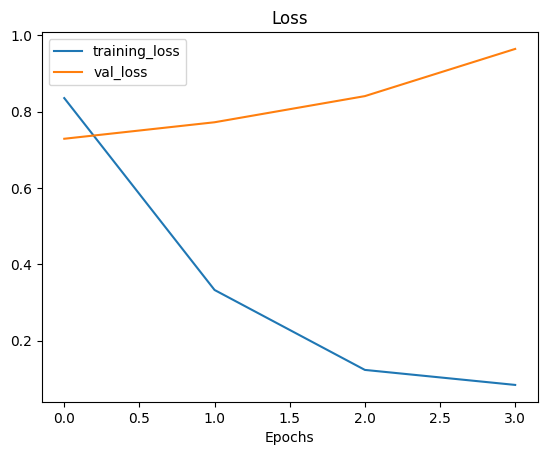

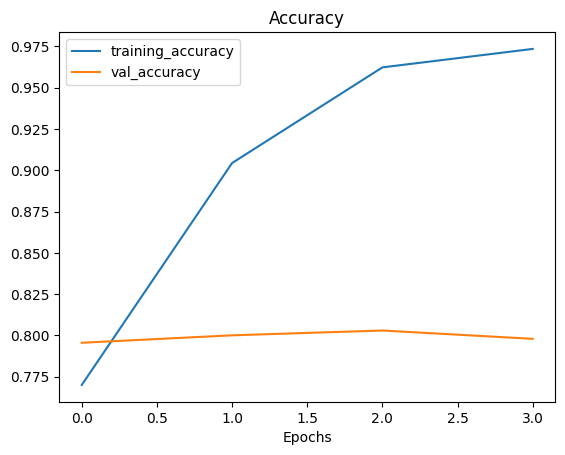

In [31]:
plot_loss_curves(history_2)

In [34]:
# predict test data
pred_probs = model_saved.predict(test_data_prefetched)
len(pred_probs)

790/790 [==============================] - 71s 90ms/step


25250

In [35]:
pred_probs.shape

(25250, 101)

In [36]:
pred_classes = pred_probs.argmax(axis = 1)
pred_classes[:10]

array([ 1, 64, 61, 74, 54, 76, 34, 90, 15,  4])

In [124]:
image = test_data_prefetched.take(1)

In [ ]:
images = []
labels = []
for i , l in image:
  images.append(i)
  labels.append(l)

Text(0.5, 1.0, 'cannoli')

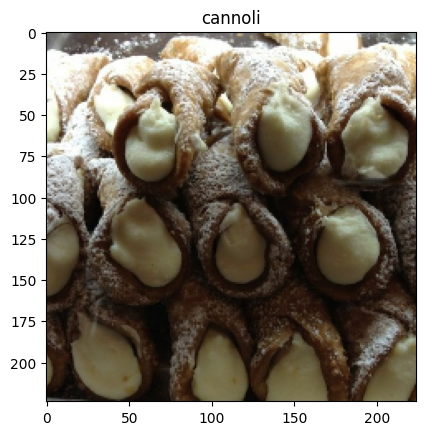

In [109]:
plt.imshow(images[0][20] / 255)
plt.title(class_names[labels[0].numpy()[20]])

In [118]:
model_saved.predict(tf.expand_dims(images[0][20], axis = 0)).argmax()

1/1 [==============================] - 0s 65ms/step


12

In [119]:
class_names[12]

'cannoli'